## Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns

## Importing the CSV file

In [ ]:
def import_dataset(file_name):
    dataframe = pd.read_excel(file_name, index_col= 0)
    return dataframe

customer_churn_raw_dataframe = import_dataset("./customer_churn_large_dataset.xlsx")

# Data Preprocessing

In [ ]:
dataset_shape = customer_churn_raw_dataframe.shape
print(f"Shape of the dataset: {dataset_shape}")
print(f"No. of rows: {dataset_shape[0]}")
print(f"No. of columns: {dataset_shape[1]}")

Shape of the dataset: (100000, 8)
No. of rows: 100000
No. of columns: 8


In [ ]:
# Checking the first few rows of the dataset
customer_churn_raw_dataframe.head(5)

,Name,Age,Gender,Location,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
CustomerID,,,,,,,,
1,Customer_1,63,Male,Los Angeles,17,73.36,236,0
2,Customer_2,62,Female,New York,1,48.76,172,0
3,Customer_3,24,Female,Los Angeles,5,85.47,460,0
4,Customer_4,36,Female,Miami,3,97.94,297,1
5,Customer_5,46,Female,Miami,19,58.14,266,0


In [ ]:
# summary (high level overview) of the dataset
customer_churn_raw_dataframe.describe()

,Age,Subscription_Length_Months,Monthly_Bill,Total_Usage_GB,Churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,44.027020,12.490100,65.053197,274.393650,0.497790
std,15.280283,6.926461,20.230696,130.463063,0.499998
min,18.000000,1.000000,30.000000,50.000000,0.000000
25%,31.000000,6.000000,47.540000,161.000000,0.000000
50%,44.000000,12.000000,65.010000,274.000000,0.000000
75%,57.000000,19.000000,82.640000,387.000000,1.000000
max,70.000000,24.000000,100.000000,500.000000,1.000000


In [ ]:
customer_churn_raw_dataframe.dtypes

Name                           object
Age                             int64
Gender                         object
Location                       object
Subscription_Length_Months      int64
Monthly_Bill                  float64
Total_Usage_GB                  int64
Churn                           int64
dtype: object

In [ ]:
# Identifying the na values present in each column
customer_churn_raw_dataframe.isna().sum()

Name                          0
Age                           0
Gender                        0
Location                      0
Subscription_Length_Months    0
Monthly_Bill                  0
Total_Usage_GB                0
Churn                         0
dtype: int64

### Inference: The given dataset does not contain any missing values.

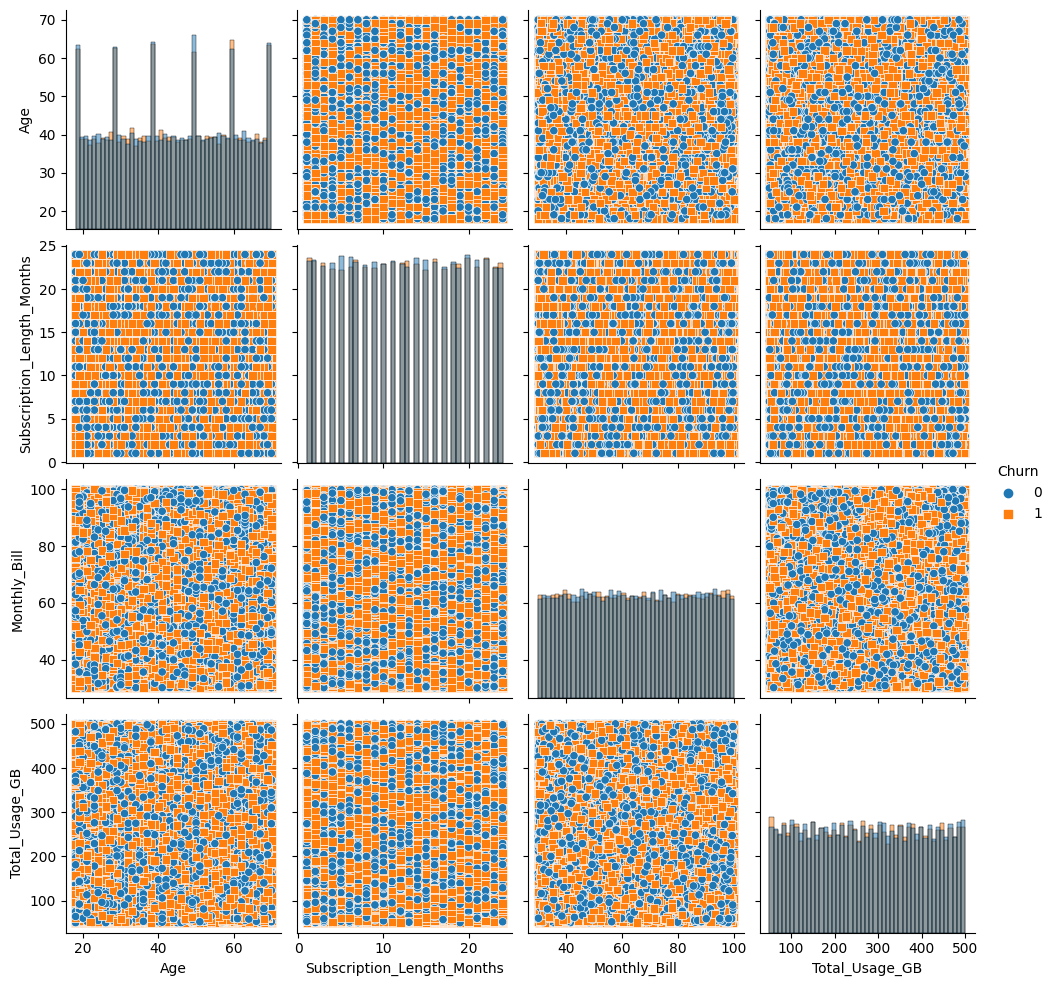

In [ ]:
sns.pairplot(customer_churn_raw_dataframe, hue= 'Churn',
             diag_kind= 'hist', markers=["o", "s"])

In [ ]:
number_of_churn = (customer_churn_raw_dataframe['Churn'] == 1).sum()
number_of_non_churn = (customer_churn_raw_dataframe['Churn'] == 0).sum()
print(f"No. of churn: {number_of_churn}")
print(f"No. of Non-churn: {number_of_non_churn}")

_= plt.hist(customer_churn_raw_dataframe['Churn'])

### Inference: The dataset seems to be balanced.

In [ ]:
fig,axs = plt.subplots(2,2, figsize= (10, 10))

sns.histplot(customer_churn_raw_dataframe['Age'], ax= axs[0][0])
sns.histplot(customer_churn_raw_dataframe['Subscription_Length_Months'], ax=axs[0][1])
sns.histplot(customer_churn_raw_dataframe['Total_Usage_GB'], ax=axs[1][0])
sns.histplot(customer_churn_raw_dataframe['Monthly_Bill'], ax=axs[1][1])

### Inference: The dataset has ample data of all ranges of values

In [ ]:
fig, axs = plt.subplots(2,2, figsize = (9,9))

sns.boxplot(x = customer_churn_raw_dataframe['Age'], ax = axs[0][0])
sns.boxplot(x = customer_churn_raw_dataframe['Subscription_Length_Months'], ax = axs[0][1])
sns.boxplot(x = customer_churn_raw_dataframe['Total_Usage_GB'], ax = axs[1][0])
sns.boxplot(x = customer_churn_raw_dataframe['Monthly_Bill'], ax = axs[1][1])

### Inference: The dataset does not seem to contain any outliers

In [ ]:
customer_churn_raw_dataframe['Location'].value_counts()

In [ ]:
customer_churn_raw_dataframe['Gender'].value_counts()

### Inference: The dataset is a well-balanced dataset with no outliers in all the features

In [ ]:
# For training purpose, 'Name' column is not required

df = customer_churn_raw_dataframe.drop(columns='Name')
df.head()

In [ ]:
# Checking if the dataset contains repeated rows
df.duplicated().sum()

0

### Inference: The dataset does not contain any duplicates

# Feature Engineering

In [ ]:
''' Applying OneHotEncoder on both 'Age' and 'Gender' and dropping the first column
to prevent multi-collinearity '''

transformer = ColumnTransformer( transformers = [
    ('gender_transform', OneHotEncoder(sparse_output=False, drop= 'first'), ['Gender']),
    ('location_transform', OneHotEncoder(sparse_output= False, drop= 'first'), ['Location']),
    ('normalizing', MinMaxScaler(), ['Age', 'Subscription_Length_Months',
                                         'Monthly_Bill', 'Total_Usage_GB'])
], remainder= 'passthrough')

pdf = pd.DataFrame(data = transformer.fit_transform(df))
pdf.shape

(100000, 10)

In [ ]:
pdf= pdf.set_index(df.index)
pdf.head()

,0,1,2,3,4,5,6,7,8,9
CustomerID,,,,,,,,,,
1,1.0,0.0,1.0,0.0,0.0,0.865385,0.695652,0.619429,0.413333,0.0
2,0.0,0.0,0.0,0.0,1.0,0.846154,0.000000,0.268000,0.271111,0.0
3,0.0,0.0,1.0,0.0,0.0,0.115385,0.173913,0.792429,0.911111,0.0
4,0.0,0.0,0.0,1.0,0.0,0.346154,0.086957,0.970571,0.548889,1.0
5,0.0,0.0,0.0,1.0,0.0,0.538462,0.782609,0.402000,0.480000,0.0


<Axes: >

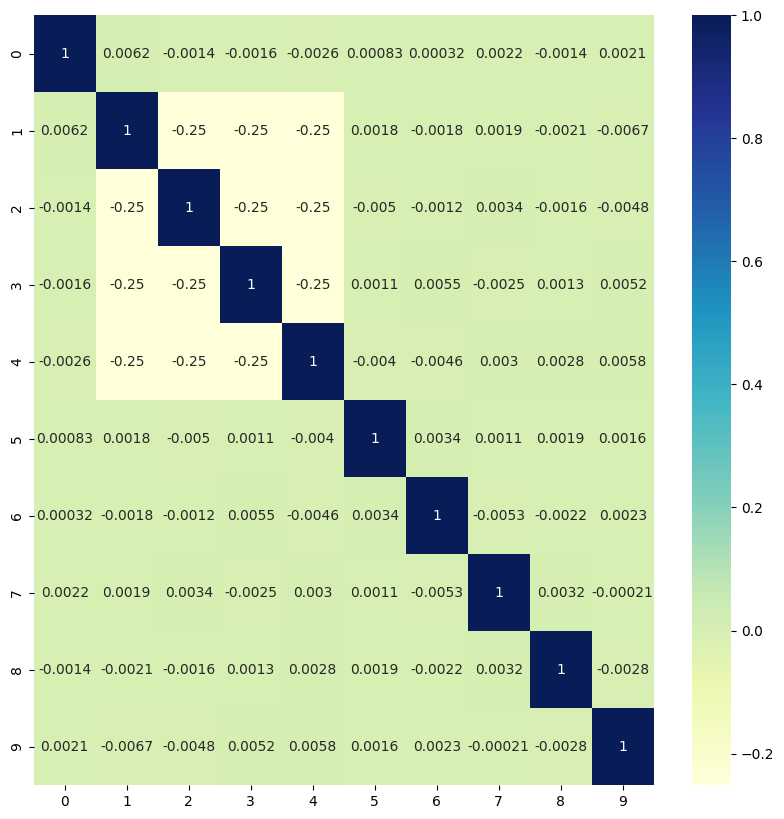

In [ ]:
plt.subplots(figsize=(10,10))
sns.heatmap(pdf.corr(), cmap="YlGnBu", annot=True)

## There is no correlation between the dependent and independent variables, hence linear based algorithms are not suitable

In [ ]:
 np.unique(pdf.iloc[:, -1] == df['Churn'], return_counts= True)
# Column 9 in pdf represents the Churn column

(array([ True]), array([100000]))

In [ ]:
x, y = pdf.iloc[:,:-1], pdf.iloc[:, -1]

In [ ]:
# train-test split (85%-15%)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.15, random_state= 0)
x_train.shape, x_test.shape

((85000, 9), (15000, 9))

# Model Building

In [ ]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    cr = classification_report(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"{cr}")
    sns.heatmap(cm, annot= True)

### Neural Network

In [ ]:
input_ = tf.keras.layers.Input(shape=(x_train.shape[-1],))
x = tf.keras.layers.Dense(32, activation = 'relu')(input_)
x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dense(64, activation = 'relu')(x)
x = tf.keras.layers.LayerNormalization()(x)
x = tf.keras.layers.Dropout(0.3)(x)
output_ = tf.keras.layers.Dense(1, activation= 'sigmoid')(x)
model = tf.keras.Model(inputs= input_, outputs= output_, name= "ChurnPredictor")

model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics= 'accuracy')
model.fit(x_train, y_train, epochs = 2, batch_size = 256, validation_data=(x_test, y_test), class_weight= {0:0.51, 1:0.49})

Epoch 1/2
333/333 [==============================] - 5s 9ms/step - loss: 0.3600 - accuracy: 0.4992 - val_loss: 0.6937 - val_accuracy: 0.5033
Epoch 2/2
333/333 [==============================] - 2s 6ms/step - loss: 0.3480 - accuracy: 0.5011 - val_loss: 0.6935 - val_accuracy: 0.4901


Accuracy: 0.4901
              precision    recall  f1-score   support

         0.0       0.49      0.44      0.46      7556
         1.0       0.49      0.54      0.51      7444

    accuracy                           0.49     15000
   macro avg       0.49      0.49      0.49     15000
weighted avg       0.49      0.49      0.49     15000



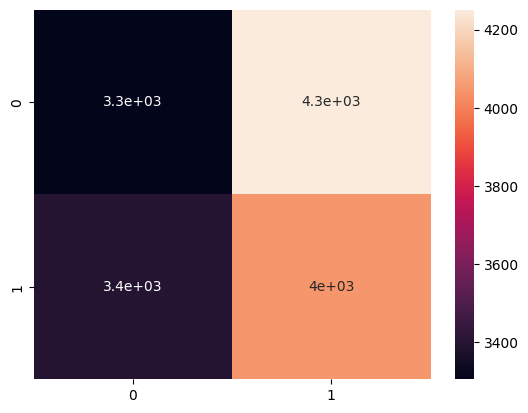

In [ ]:
y_pred = model.predict(x_test, verbose = 0)
y_pred = np.where(y_pred<0.5, 0, 1)
metrics(y_test, y_pred)

In [ ]:
model.save('nn.h5')